# P&D ISSP 2023 - Base notebook
@Students: Edit everything you want!

Packages

In [46]:
import matplotlib
import soundfile
import os
import package.general as genfcns
import package.gui_utils as guifcns
matplotlib.style.use('default')  # <-- for notebooks: white figures background

# Root path (path to where you are storing this very notebook)
#  /!/  Adapt this to your system  /!/ 
ROOTPATH = 'C:/Users/uprub/Documents/PandD/pandd2023-base'

pathToSoundFiles = f'{ROOTPATH}/sound_files/'

# Parameters
speechfilenames = [
    pathToSoundFiles + 'speech1.wav',
    pathToSoundFiles + 'speech2.wav'
]
noisefilenames = [
    pathToSoundFiles + 'Babble_noise1.wav'
]
signalDuration = 10     # [s]
muGSC = 0.1     # NLMS update constant for freq.-domain GSC

Build acoustic scenario and generate RIRs using GUI

In [67]:
# Launch GUI
guifcns.RIRg_GUI(
    exportFolder=f'{os.getcwd()}/rirs',
    outputRIRplot=False,
    distBwMics=10,  # [cm]
    fs=44100,
    t60=0,
    theme='SystemDefault',
)



Note that the RIRs are sampled at 44100 Hz.
PyRoomAcoustics is computing the 15 RIRs...
RIRs computed successfully. Saving as Pickle archive.
RIRs saved in file: "rirs_20250226_20h15m06s.pkl.gz", in folder
"c:\Users\uprub\Documents\PandD\pandd2023-base\rirs"


Acoustic scenario object containing the RIRs, with parameters:
>> Field "audioCoords": [[np.float64(21.875), np.float64(12.625)], [np.float64(21.75), np.float64(15.5)]]
>> Field "audioIds": ['131', '132']
>> Field "c": 340
>> Field "distBwMics": 0.1
>> Field "exportFolder": c:\Users\uprub\Documents\PandD\pandd2023-base/rirs
>> Field "fs": 44100
>> Field "lineIds": [1, 3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 23, 25, 27, 29, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124]
>> Field "lineTextIds": [2, 5, 7, 9, 11, 13, 15, 17, 19, 21, 24, 26, 28, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125]
>> Field "micsCoords": [[np.float64(23.625), np.float64(14.499999999999998)], [np.float64(

In [68]:
from package.gui_utils import load_rirs
current_rir = "C:/Users/uprub/Documents/PandD/pandd2023-base/rirs/rirs_20250226_20h15m06s.pkl.gz"
acousticScenario = load_rirs(path=current_rir) # loads the data
roomDim = acousticScenario.roomDim # access the room dimension [m]
print(acousticScenario) # print out all parameters

Acoustic scenario object containing the RIRs, with parameters:
>> Field "audioCoords": [[np.float64(21.875), np.float64(12.625)], [np.float64(21.75), np.float64(15.5)]]
>> Field "audioIds": ['131', '132']
>> Field "c": 340
>> Field "distBwMics": 0.1
>> Field "exportFolder": c:\Users\uprub\Documents\PandD\pandd2023-base/rirs
>> Field "fs": 44100
>> Field "lineIds": [1, 3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 23, 25, 27, 29, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124]
>> Field "lineTextIds": [2, 5, 7, 9, 11, 13, 15, 17, 19, 21, 24, 26, 28, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125]
>> Field "micsCoords": [[np.float64(23.625), np.float64(14.499999999999998)], [np.float64(

RIRs selection

Text(0.5, 1.0, 'RIR of source 1 to microphone 2')

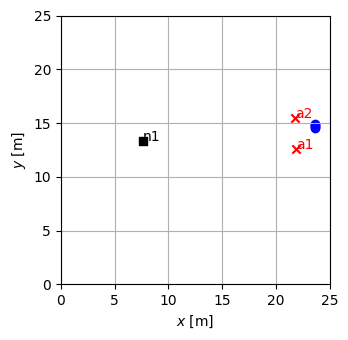

<Figure size 640x480 with 0 Axes>

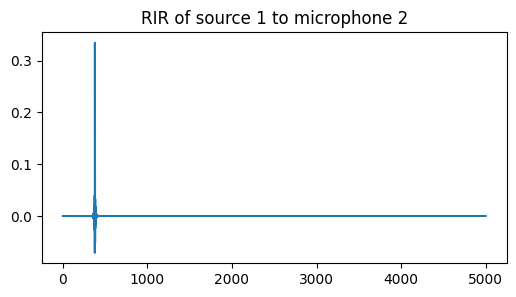

In [69]:
import matplotlib.pyplot as plt
# Select RIRs to be used
# rirFile = 'rirs/'  # use this to input a specific set of RIRs (full path to .pkl.gz file)
#rirFile = genfcns.select_latest_rir(path='./rirs/')  # use this to select the lastly generated RIRs
rirFile = current_rir
# Load from Pickle archive
acousticScenario = guifcns.load_rirs(path=rirFile)
# >>> NB: the RIRs can be accessed as acousticScenario.RIRsAudio /or/ RIRsNoise
acousticScenario.plot_asc()  # show the acoustic scenario as a pl

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(acousticScenario.RIRsAudio[0:5000,1,0])
plt.title("RIR of source 1 to microphone 2")

# plt.figure()
# plt.figure(figsize=(6, 3))
# plt.plot(acousticScenario.RIRsNoise[:,0,0])
# print(acousticScenario.RIRsAudio.shape)
# print(acousticScenario)

# print(acousticScenario.RIRsAudio)
# print(acousticScenario.RIRsNoise.shape)
# print(acousticScenario)

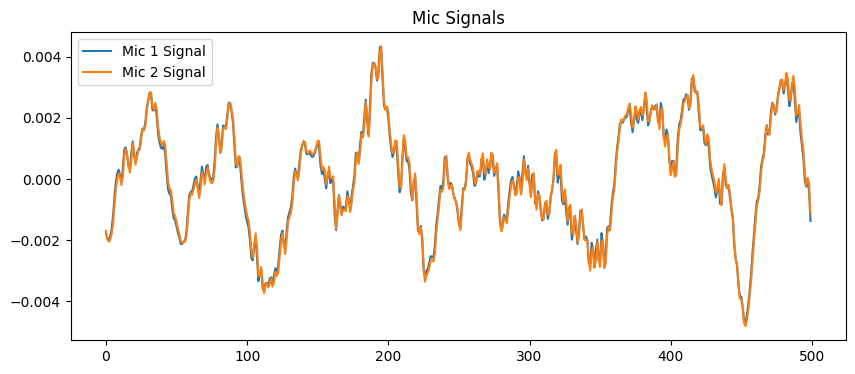

(220500, 5)


In [51]:
# Part 2
import scipy
import numpy as np
import soundfile as sf
import scipy.signal as signal
import sounddevice as sd

def create_micsigs(target_audio_files, noise_audio_files, acousticScenario, T_s, hmr_paths):
    
    if len(hmr_paths) == 0:
        num_micro = acousticScenario.RIRsAudio.shape[1]   # number of microphones
        # num_audio = acousticScenario.RIRsAudio.shape[2]   # number of audio sources
        # num_noise = acousticScenario.RIRsNoise.shape[2]   # number of noise sources
        fs = acousticScenario.fs
        T_ds = int(T_s * fs)

        # Load and resample target audio sources
        speech_components = []
        for file in target_audio_files:
            speech, fs_audio = sf.read(file)
            speech_resampled = signal.resample(speech, int(len(speech) * fs / fs_audio)) if fs != fs_audio else speech
            speech_padded = np.pad(speech_resampled[:T_ds], (0, max(0, T_ds - len(speech_resampled))))
            speech_components.append(speech_padded)
        
        # Load and resample noise sources
        noise_components = []
        for file in noise_audio_files:
            noise, fs_noise = sf.read(file)
            noise_resampled = signal.resample(noise, int(len(noise) * fs / fs_noise)) if fs != fs_noise else noise
            noise_padded = np.pad(noise_resampled[:T_ds], (0, max(0, T_ds - len(noise_resampled))))
            noise_components.append(noise_padded)
        mic_signals = np.zeros((T_ds, num_micro))
        for mic_idx in range(num_micro):
            mic_signal = np.zeros(T_ds)
            for audio_idx, speech in enumerate(speech_components):
                rir_speech = acousticScenario.RIRsAudio[:, mic_idx, audio_idx]
                #rir_speech /= np.max(np.abs(rir_speech))
                mic_signal += signal.fftconvolve(speech, rir_speech, mode='same')
            for noise_idx, noise in enumerate(noise_components):
                rir_noise = acousticScenario.RIRsNoise[:, mic_idx, noise_idx]
                #rir_noise /= np.max(np.abs(rir_noise))
                mic_signal += signal.fftconvolve(noise, rir_noise, mode='same')

            mic_signals[:, mic_idx] = mic_signal
    else:
        all_paths = []
        for fpath in hmr_paths:
            all_paths.append([fpath + "/HMIR_L1.wav",fpath + "/HMIR_L2.wav",fpath + "/HMIR_R1.wav",fpath + "/HMIR_R2.wav"])
        fs = sf.read(all_paths[0][0])[1]
        T_ds = int(T_s * fs)

        # Load and resample target audio sources
        speech_components = []
        noise_components = []
        for file in target_audio_files:
            speech, fs_audio = sf.read(file)
            fs = fs_audio
            speech_resampled = signal.resample(speech, int(len(speech) * fs / fs_audio)) if fs != fs_audio else speech
            speech_padded = np.pad(speech_resampled[:T_ds], (0, max(0, T_ds - len(speech_resampled))))
            speech_components.append(speech_padded)
        num_micro = 4
        mic_signals = np.zeros((T_ds, num_micro))
        for mic_idx in range(num_micro):
            mic_signal = np.zeros(T_ds)
            for audio_idx, speech in enumerate(speech_components):
                rir_speech = sf.read(all_paths[audio_idx][mic_idx])[0]
                rir_speech /= np.max(np.abs(rir_speech))
                mic_signal += signal.fftconvolve(speech, rir_speech, mode='same')
        
            mic_signals[:, mic_idx] = mic_signal
            
    

    # Plot first two microphone signals
    # for mic_idx in range(num_micro):
    #     plt.figure(figsize=(10, 4))
    #     plt.plot(mic_signals[:, mic_idx], label=f'Mic {mic_idx + 1}')
    #     plt.title(f"Microphone {mic_idx + 1} Signal")
    #     # plt.xlim((6425,6470))
    #     plt.xlabel("Samples")
    #     plt.ylabel("Amplitude")
    #     plt.legend()
    #     plt.show()
    
    return mic_signals, speech_components, noise_components, fs

hm_sources = ["C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/head_mounted_rirs/s30"]
Time_duration = 5
mic, speech, noise, _ = create_micsigs(["C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/rep_part1_track1_dry.wav","C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/rep_part1_track1_dry.wav"], ["C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/Babble_noise1.wav"], acousticScenario, Time_duration, [])
plt.figure(figsize=(10, 4))
plt.plot(mic[5500:6000, 0], label="Mic 1 Signal")
plt.plot(mic[5500:6000, 1], label="Mic 2 Signal")
plt.legend()
plt.title("Mic Signals")
plt.show()


# sd.play(speech1[0:fs*1], fs)
# sd.play(mic[:,0], fs)

print(mic.shape)
# Play the first microphone signal
sd.play(mic[:, 0], samplerate=acousticScenario.fs)
sd.wait()  # Wait until playback finishes

Ground truth TDOA: -0.000204 seconds
Estimated TDOA: -0.000204 seconds


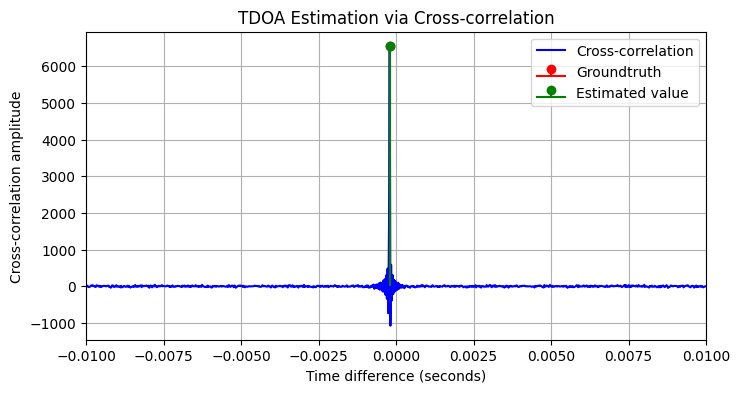

TDOA estimation error: 0.000000 seconds


In [ ]:
#Part 3 new
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def TDOA_corr(audio1_name, acousticScenario, Ts):
    """
    Estimate the Time Difference of Arrival (TDOA) using cross-correlation between two microphone signals.
    
    Args:
        audio1_name: Path to the white noise audio file.
        acousticScenario: Acoustic scenario object with RIRs and sampling frequency.
        Ts: Sampling period or time step.
    Returns:
        None
    """
    # Extract the RIRs for the two microphones
    rir1 = acousticScenario.RIRsAudio[:, 0, 0]  # RIR for mic 1
    rir2 = acousticScenario.RIRsAudio[:, 1, 0]  # RIR for mic 2
    
    # Identify the sample delay between the direct path components
    direct_path_idx1 = np.argmax(np.abs(rir1))  # Find the direct path peak for mic 1
    direct_path_idx2 = np.argmax(np.abs(rir2))  # Find the direct path peak for mic 2

    # Calculate the ground truth TDOA in seconds
    ground_truth_TDOA = (direct_path_idx1 - direct_path_idx2) / acousticScenario.fs
    print(f"Ground truth TDOA: {ground_truth_TDOA:.6f} seconds")

    # Generate the microphone signals from the scenario (using the provided create_micsigs function)
    mic_signals, _, _, _ = create_micsigs([audio1_name], [], acousticScenario, Ts, [])
    mic1 = mic_signals[:, 0]  # Signal from microphone 1
    mic2 = mic_signals[:, 1]  # Signal from microphone 2

    # Cross-correlation between the two microphone signals
    cross_corr = signal.correlate(mic1, mic2, mode="full")
    lags = signal.correlation_lags(len(mic1), len(mic2), mode="full")

    # Estimate the TDOA by finding the lag with the maximum correlation
    estimated_TDOA = lags[np.argmax(cross_corr)] / acousticScenario.fs
    print(f"Estimated TDOA: {estimated_TDOA:.6f} seconds")

    # Plot the time-domain cross-correlation function
    plt.figure(figsize=(8, 4))
    plt.plot(lags / acousticScenario.fs, cross_corr, label="Cross-correlation", color='b')
    
    # Plot the ground truth TDOA (as a red marker)
    plt.stem([ground_truth_TDOA], [np.max(cross_corr)], linefmt="r-", markerfmt="ro", basefmt="r-", label="Groundtruth")
    
    # Plot the estimated TDOA (as a green marker)
    plt.stem([estimated_TDOA], [np.max(cross_corr)], linefmt="g-", markerfmt="go", basefmt="g-", label="Estimated value")

    plt.xlabel("Time difference (seconds)")
    plt.ylabel("Cross-correlation amplitude")
    plt.legend()
    plt.title("TDOA Estimation via Cross-correlation")
    plt.xlim(-0.01, 0.01)  # Adjust the x-axis limit as necessary
    plt.grid(True)
    plt.show()

    # Print the difference between the estimated TDOA and the ground truth TDOA
    error = np.abs(estimated_TDOA - ground_truth_TDOA)
    print(f"TDOA estimation error: {error:.6f} seconds")
    
# Example usage
TDOA_corr("C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/whitenoise_signal_1.wav", acousticScenario, 5)






In [18]:
#Part 4 new

import numpy as np
import scipy.signal as signal

def TDOA_corr(mic_signal_1, mic_signal_2, fs):
    """
    Estimate the Time Difference of Arrival (TDOA) using cross-correlation.
    
    Parameters:
    mic_signal_1, mic_signal_2 : numpy arrays
        Microphone signals.
    fs : int
        Sampling frequency in Hz.
    
    Returns:
    TDOA in seconds.
    """
    corr = signal.correlate(mic_signal_1, mic_signal_2, mode='full')
    lags = signal.correlation_lags(len(mic_signal_1), len(mic_signal_2), mode='full')
    
    max_lag = lags[np.argmax(corr)]
    TDOA = max_lag / fs  # Convert samples to time
    
    return TDOA

def DOA_corr(mic_signal_1, mic_signal_2, d, fs, c=340):
    """
    Estimate Direction of Arrival (DOA) using TDOA.
    
    Parameters:
    mic_signal_1, mic_signal_2 : numpy arrays
        Microphone signals.
    d : float
        Inter-microphone distance in meters.
    fs : int
        Sampling frequency in Hz.
    c : float, optional
        Speed of sound in m/s (default is 340 m/s).
    
    Returns:
    DOA estimate(s) in a Python list.
    """
    TDOA = TDOA_corr(mic_signal_1, mic_signal_2, fs)
    
    # Convert TDOA to DOA using the far-field model
    theta_rad = np.arccos((TDOA * c) / d)  # Angle in radians
    theta_deg = np.degrees(theta_rad)  # Convert to degrees
    
    # Ensure DOA is within [0, 180]
    theta_deg = np.clip(theta_deg, 0, 180)
    
    return [theta_deg]

# Reconstruct the first (non-reverberant) scenario of Part 2
fs = acousticScenario.fs  # Sampling frequency in Hz
d = acousticScenario.distBwMics  # Inter-microphone distance in meters

# Load a speech signal (assuming it is stored in a NumPy array)
# Replace 'speech_signal.npy' with the actual path to the speech signal file


mic_signals, _, _, _ = create_micsigs(["C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/whitenoise_signal_1.wav"], [], acousticScenario, 5, [])
mic1 = mic_signals[:, 0]  # Signal from microphone 1
mic2 = mic_signals[:, 1]  # Signal from microphone 2


DOA_estimate = DOA_corr(mic1, mic2, d, fs)
print("Estimated DOA:", DOA_estimate[0])

Estimated DOA: 128.08137571806267


In [ ]:
# Part 5
def TDOA_corr_2(audio1_name, audio2_name, noise_name, acousticScenario, mic, Ts):
 rir1_1 = acousticScenario.RIRsAudio[:,mic[0],0]
 rir2_1 = acousticScenario.RIRsAudio[:,mic[1],0]

 direct_path_idx1_1 = np.argmax(np.abs(rir1_1))
 direct_path_idx2_1 = np.argmax(np.abs(rir2_1))

 ground_truth_TDOA_1 = (direct_path_idx1_1 - direct_path_idx2_1) / acousticScenario.fs

 print(f"Ground truth TDOA of source 1: {ground_truth_TDOA_1:.6f} seconds")

 rir1_2 = acousticScenario.RIRsAudio[:,mic[0],1]
 rir2_2 = acousticScenario.RIRsAudio[:,mic[1],1]

 direct_path_idx1_2 = np.argmax(np.abs(rir1_2))
 direct_path_idx2_2 = np.argmax(np.abs(rir2_2))

 ground_truth_TDOA_2 = (direct_path_idx1_2 - direct_path_idx2_2) / acousticScenario.fs

 print(f"Ground truth TDOA of source 2: {ground_truth_TDOA_2:.6f} seconds")

 mic_signals, _, _, _  = create_micsigs([audio1_name, audio2_name], [], acousticScenario, Ts, [])
 mic1 = mic_signals[:, 0] # Signal of the first mic
 mic2 = mic_signals[:, 1] # Signal of the second mic

 cross_corr = signal.correlate(mic1, mic2, mode="full")
 lags = signal.correlation_lags(len(mic1), len(mic2), mode="full")

 cross_corr /= np.max(np.abs(cross_corr))
 peaks, properties = signal.find_peaks(cross_corr, height=0.2) # Peaks above 50% of max

 if len(peaks) < 2:
  raise ValueError("Less than 2 peaks found. Cannot estimate exactly 2 DOAs.")

 # Select the two highest peaks
 peak_indices = np.argsort(properties["peak_heights"])[-2:] # Get indices of top 2 peaks
 selected_peaks = peaks[peak_indices]

 TDOAestAll = []

 for peak in selected_peaks:
    estimated_TDOA = lags[peak] / acousticScenario.fs
    TDOAestAll.append(estimated_TDOA)

 estimated_TDOA = lags[np.argmax(cross_corr)] / acousticScenario.fs

 print(f"First estimated TDOA: {TDOAestAll[1]:.6f} seconds")
 print(f"Second estimated TDOA: {TDOAestAll[0]:.6f} seconds")

 c = 340 # Speed of sound in air (m/s)
 mic_distance = acousticScenario.distBwMics
 TDOAestAll = np.array(TDOAestAll)
 cos_theta = (TDOAestAll * c) / mic_distance # estimated cosine of the angle
 cos_theta = np.clip(cos_theta, -1, 1)
 DOA_estimate = np.arccos(cos_theta) * (180 / np.pi) # Angle in degrees

 print(f"estimated DOA: {DOA_estimate[1]:.2f} degrees")
 print(f"estimated DOA: {DOA_estimate[0]:.2f} degrees")

TDOA_corr_2("C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/whitenoise_signal_1.wav", "C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/whitenoise_signal_2.wav", "", acousticScenario, [0, 1], 5)


Ground truth TDOA of source 1: -0.000181 seconds
Ground truth TDOA of source 2: 0.000181 seconds
First estimated TDOA: -0.000181 seconds
Second estimated TDOA: 0.000181 seconds
estimated DOA: 128.08 degrees
estimated DOA: 51.92 degrees


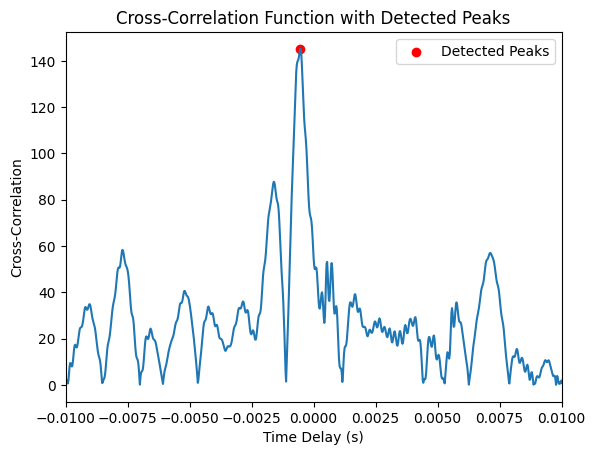

[np.float64(0.03310657596371882), np.float64(-0.0005442176870748299)]
[np.float64(0.0), np.float64(149.38664131918648)]
[np.float64(0.0), np.float64(149.38664131918648)]
[np.float64(0.0), np.float64(149.38664131918648)]



In [27]:
# Part 6
import numpy as np
import soundfile as sf
import scipy.signal as sig
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('C:/Users/uprub/Documents/PandD/pandd2023-base/package')

from general import listen_to_array


def estimate_tdoa(mic1, mic2, fs, num_peaks=2):
    """Estimates the time differences of arrival (TDOAs) for up to two sources using cross-correlation."""
    if num_peaks == 2:
        """Estimates the time differences of arrival (TDOAs) for two sources, one positive and one negative, using cross-correlation."""
        corr = sig.correlate(mic1, mic2, mode='full')
        delays = sig.correlation_lags(len(mic1), len(mic2), mode='full')
        
        # Find peak indices in cross-correlation for both positive and negative lags
        peak_indices, _ = sig.find_peaks(np.abs(corr))  # Avoid detecting very close peaks
        peak_values = corr[peak_indices]
        
        # Separate the peaks into positive and negative lags
        positive_peak_indices = peak_indices[delays[peak_indices] > 0]
        negative_peak_indices = peak_indices[delays[peak_indices] < 0]
        
        # Find the peak with the largest positive value (positive lag)
        positive_peak_index = positive_peak_indices[np.argmax(np.abs(corr[positive_peak_indices]))]
        # Find the peak with the largest negative value (negative lag)
        negative_peak_index = negative_peak_indices[np.argmax(np.abs(corr[negative_peak_indices]))]

        # Convert to time differences (TDOAs)
        tdoa_positive = delays[positive_peak_index] / fs
        tdoa_negative = delays[negative_peak_index] / fs
        
        # Plot cross-correlation with detected peaks
        plt.figure()
        plt.plot(delays / fs, np.abs(corr))
        plt.scatter([tdoa_positive, tdoa_negative], [corr[positive_peak_index], corr[negative_peak_index]], color='red', label="Detected Peaks")
        plt.xlabel("Time Delay (s)")
        plt.ylabel("Cross-Correlation")
        plt.title("Cross-Correlation Function with Detected Peaks")
        plt.xlim((-0.01, 0.01))
        plt.legend()
        plt.show()

        return [tdoa_positive, tdoa_negative]  # Return the TDOAs for both peaks
    else:
        corr = sig.correlate(mic1, mic2, mode='full')
        delays = sig.correlation_lags(len(mic1), len(mic2), mode='full')
        
        # Find peak indices in cross-correlation
        peak_indices, _ = sig.find_peaks(np.abs(corr))  # Avoid detecting very close peaks
        peak_values = corr[peak_indices]
        
        # Select the top 'num_peaks' largest peaks by absolute value
        abs_peak_values = np.abs(peak_values)  # Get absolute values of peaks
        top_peaks = np.argsort(abs_peak_values)[-num_peaks:]  # Get indices of the two highest peaks by magnitude
        top_peaks = peak_indices[top_peaks]  # Convert to actual peak indices
        top_peaks = np.sort(top_peaks)  # Sort to maintain order
        
        tdoas = delays[top_peaks] / fs  # Convert to time (s)
        
        # Plot cross-correlation with peaks
        plt.figure()
        plt.plot(delays / fs, corr)
        plt.scatter(tdoas, corr[top_peaks], color='red', label="Detected Peaks")
        plt.xlabel("Time Delay (s)")
        plt.ylabel("Cross-Correlation")
        plt.title("Cross-Correlation Function with Detected Peaks")
        plt.xlim((-0.01, 0.01))
        plt.legend()
        plt.show()

        return tdoas  # Return list of detected TDOAs

def estimate_doa(tdoas, mic_spacing, c=340):
    """Converts TDOAs into DOA estimates for multiple sources."""
    doas = []
    for tdoa in tdoas:
        cos_theta = (tdoa * c) / mic_spacing
        cos_theta = np.clip(cos_theta, -1, 1)  # Ensure valid range
        theta = np.arccos(cos_theta) * (180 / np.pi)
        doas.append(theta)
    return doas  # Return list of DOAs

# Paths to impulse responses and target audio
rir_path = "C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/head_mounted_rirs/s-60"
rir_path_2 = "C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/head_mounted_rirs/s60"
audio_file = "C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/part1_track1_dry.wav"
audio_file_2 = "C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/part1_track2_dry.wav"
mic_signals, _, _, fs = create_micsigs([audio_file, audio_file_2], [], acousticScenario, 10, [rir_path, rir_path_2])
tdoa = estimate_tdoa(mic_signals[:, 0], mic_signals[:, 2], fs,2)
print(tdoa)
mic_spacing = 0.215 # 0.215 m for front ones and 0.013 m for the side ones
doa = estimate_doa(tdoa, mic_spacing)
print(doa)
for d in doa:
    print(doa)
binaural_signal = mic_signals[:, [0, 2]]  # Extract first and third columns
binaural_signal = np.ascontiguousarray(binaural_signal)  # Make sure it's contiguous


print()
# Play the binaural signal
listen_to_array(binaural_signal, fs)
#print(f"DOA estimate for L1 & L2: {doa:.2f}°")






# Signal processing - Week 2: MUSIC algorithm

Computing DOAs via freq.-domain MUSIC algorithm...
All estimated DOAs: [0.]
Oracle-selected estimated DOAs: [0.]
Target DOAs estimate error(s): [-75.] deg.


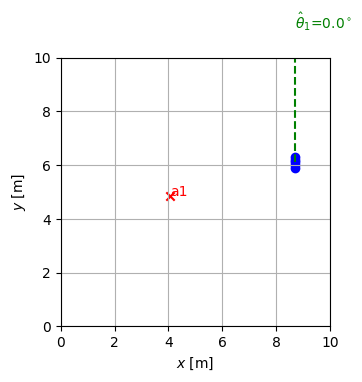

In [9]:
import numpy as np

winLength = 1024 # Window length
nSources = acousticScenario.RIRsAudio.shape[-1] #+\
#    acousticScenario.RIRsNoise.shape[-1] # Number of sources
theta = np.arange(0, np.pi, step=np.pi / 360)  # angles to consider

print('Computing DOAs via freq.-domain MUSIC algorithm...')


# DOAestAll = yourMUSIC() ...
DOAestAll = np.zeros(nSources)  # default


print(f'All estimated DOAs: {DOAestAll * 180/np.pi}')

# ------------------ DOA estimation performance check ------------------
# Oracle selection of the target DOA
DOAest, oracleDOAtalkers = genfcns.oracle_choice_doa(
    DOAestAll, acousticScenario
)
print(f'Oracle-selected estimated DOAs: {DOAest * 180/np.pi}')
# Check validity
genfcns.check_plot_tdoas(DOAest, DOAestAll, acousticScenario)
print(f'Target DOAs estimate error(s): {np.round((DOAest - oracleDOAtalkers) * 180/np.pi, 1)} deg.')

In [10]:
#frequency check
if acousticScenario.fs == 44100:
    print("Correct sampling frequency: 44.1 kHz")
else:
    raise ValueError(f"False: Incorrect sampling frequency, current sampling frequency {acousticScenario.fs} Hz")

Correct sampling frequency: 44.1 kHz


In [20]:
# STFT
import numpy as np
from scipy.signal import stft

# parameters
fs = 44100         # sampling frequency
L = 1024           # window length
hop = L // 2       # 50% overlap
M = mic.shape[1]   # number of microphones
n_samples = mic.shape[0]  # number of samples

stft_mics_list = []

for m in range(M):
    mic_signal = mic[:, m]
    
    f, t, Zxx = stft(mic_signal,
                     fs=fs,
                     window='hann',   # 'hann', 'boxcar'
                     nperseg=L,
                     noverlap=hop,
                     return_onesided=True)

    stft_mics_list.append(Zxx)  # shape: (nF, nT)

stft_mics = np.array(stft_mics_list)  # (M, nF, nT)

print("stft_mics shape:", stft_mics.shape)

stft_mics shape: (4, 513, 432)


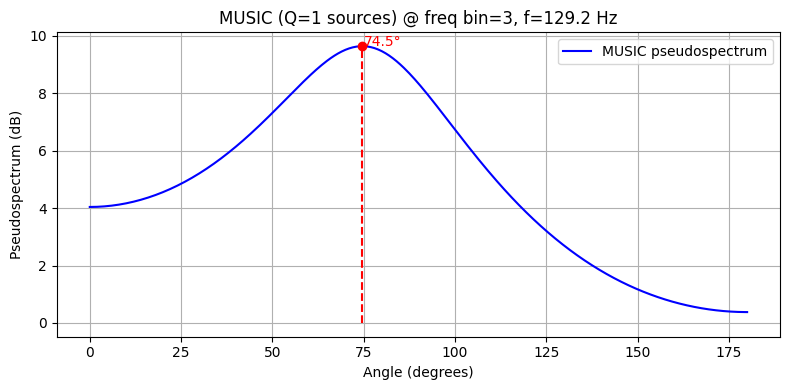

In [ ]:
# narrowband
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def music_narrowband(stft_mics, Q, d, c):   
    M, _, nT = stft_mics.shape
    
    power_per_bin = np.mean(np.abs(stft_mics)**2, axis=(0, 2))  # shape: (nF,)
    # power_per_bin[0] = 0  # Avoid DC bin
    
    fidx = np.argmax(power_per_bin) 
    
    f_bin = f[fidx]
    
    X_omega = stft_mics[:, fidx, :]  # shape: (M, nT)
    Rxx = (X_omega @ X_omega.conj().T) / nT  # (M, M)
    
    eigenvals, eigenvecs = np.linalg.eig(Rxx)
    sort_idx = np.argsort(eigenvals)       
    # eigenvals_sorted = eigenvals[sort_idx]
    eigenvecs_sorted = eigenvecs[:, sort_idx]
    
    Un = eigenvecs_sorted[:, :M - Q]  # shape (M, M-Q)  

    theta_vals = np.arange(0, 180.5, 0.5)
    k0 = 2 * np.pi * f_bin / c  # wave number
    P_music = []
    
    m_index = np.arange(M)  # microphone index
    
    for theta_deg in theta_vals:
        theta_rad = np.deg2rad(theta_deg)
        steer = np.exp(-1j * k0 * m_index * d * np.cos(theta_rad))  # (M,)
        
        v = Un.conj().T @ steer  # shape = (M-Q,)
        denom = np.abs(v @ v.conj())
        pseudospec = 1.0 / denom
        P_music.append(pseudospec)
        
    P_music = np.array(P_music)  # shape (len(theta_vals),)
    
    # peak_indices = np.argsort(P_music)[-Q:]   # Take the last Q elements (the largest Q elements)
    # peak_indices = peak_indices[::-1]         # Sort from largest to smallest  
    # doa_estimates = theta_vals[peak_indices]  # Angles (°), possibly unordered

    peaks, _ = find_peaks(P_music, distance=5, prominence=0.1)
    
    if len(peaks) == 0:
        print("Warning: no peak found!")
        doa_estimates = np.array([])
    else:
        peak_values_all = P_music[peaks]
        if len(peaks) < Q:
            topQ_idx = np.argsort(peak_values_all)[::-1]  # Sort in descending order
        else:
            topQ_idx = np.argsort(peak_values_all)[-Q:]  # Take the largest Q peaks

        topQ_idx_sorted = topQ_idx[np.argsort(peak_values_all[topQ_idx])]  
        
        peak_indices = peaks[topQ_idx_sorted]
        doa_estimates = theta_vals[peak_indices]
    
    plt.figure(figsize=(8,4))
    plt.plot(theta_vals, 10*np.log10(P_music), 'b-', label='MUSIC pseudospectrum')
    
    for idx in peak_indices:
        peak_angle = theta_vals[idx]
        peak_value = 10*np.log10(P_music[idx])
        plt.stem([peak_angle], [peak_value], linefmt='r--', markerfmt='ro', basefmt=" ")
        plt.text(peak_angle+0.5, peak_value, f"{peak_angle:.1f}°", color='red')
    
    plt.title(f"MUSIC (Q={Q} sources) @ freq bin={fidx}, f={f_bin:.1f} Hz")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Pseudospectrum (dB)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return doa_estimates

doa_estimates = music_narrowband(stft_mics, acousticScenario.RIRsAudio.shape[2], acousticScenario.distBwMics, c=340)
# doa_estimates = music_narrowband(stft_mics, 1, 0.013, 340)


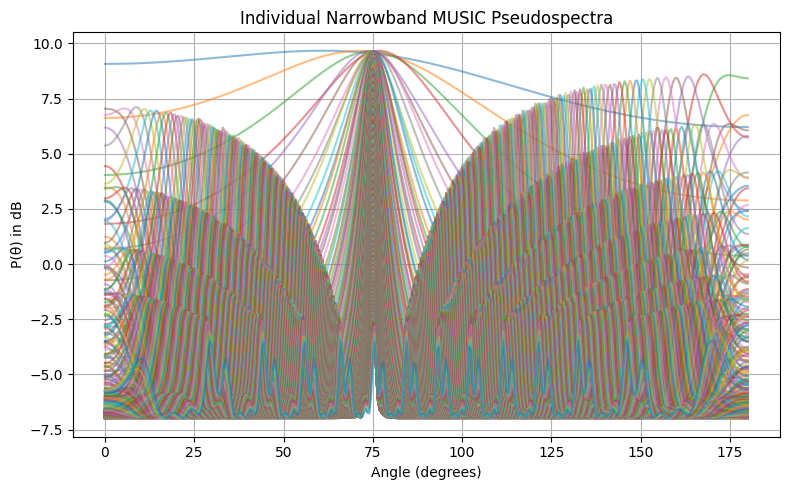

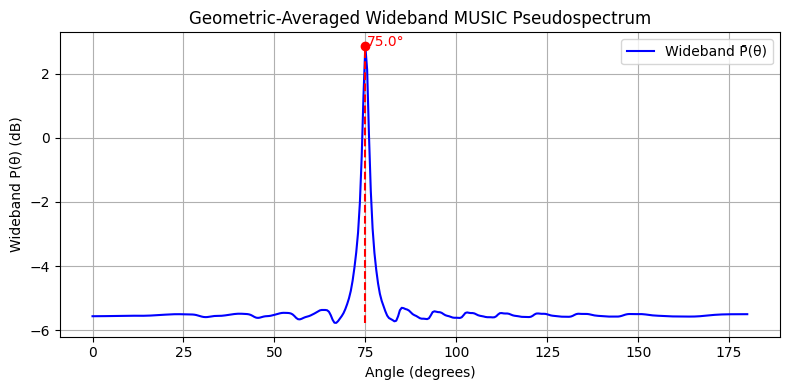

In [ ]:
# wideband
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def music_wideband(stft_mics, Q, d, c):
    M, nF, nT = stft_mics.shape
    
    theta_vals = np.arange(0, 180.5, 0.5)
    nTheta = len(theta_vals)
    
    freq_bins = range(1, nF-1)  
    nFreqUsed = len(freq_bins)
    
    all_pseudospec = np.zeros((nFreqUsed, nTheta), dtype=float)
    
    for i, fidx in enumerate(freq_bins):
        f_bin = f[fidx]
        
        X_omega = stft_mics[:, fidx, :]  # (M, nT)
        Rxx = (X_omega @ X_omega.conj().T) / nT
        
        eigenvals, eigenvecs = np.linalg.eig(Rxx)
        sort_idx = np.argsort(eigenvals)
        Un = eigenvecs[:, sort_idx[:(M-Q)]]  # (M, M-Q)
        
        k0 = 2.0 * np.pi * f_bin / c
        m_index = np.arange(M)
        
        for j, theta_deg in enumerate(theta_vals):
            theta_rad = np.deg2rad(theta_deg)
            steer = np.exp(-1j * k0 * m_index * d * np.cos(theta_rad))  # can be sin
            
            v = Un.conj().T @ steer
            denom = np.abs(v @ v.conj())
            pseudospec = 1.0 / denom
            
            all_pseudospec[i, j] = pseudospec
    
    plt.figure(figsize=(8,5))
    for i in range(nFreqUsed):
        plt.plot(theta_vals, 10*np.log10(all_pseudospec[i, :]), alpha=0.5, label=f"bin {freq_bins[i]}")
    plt.title("Individual Narrowband MUSIC Pseudospectra")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("P(θ) in dB")
    plt.grid(True)
    # plt.legend(loc='best', ncol=2, fontsize='small')
    plt.tight_layout()
    plt.show()
    
    log_all = np.log(all_pseudospec + 1e-15)  # Avoid log(0)
    mean_log = np.mean(log_all, axis=0)      
    p_wideband = np.exp(mean_log)   # shape: (nTheta,)

    if Q == 1:
        peaks = np.argmax(p_wideband)
        peaks = np.array([peaks])
    else:
        peaks, properties = find_peaks(
            p_wideband,
            distance=4,     # At least a few sample points apart (approximately 2.5° = 5 * 0.5°)
            prominence=0.05,  # Adjust based on data
            # height=0.6 * np.max(p_wideband)  # Filter out peaks smaller than 60% of the maximum value
        )
    
    if len(peaks) == 0:
        print("Warning: no peak found!")
        doa_estimates = np.array([])
    else:
        peak_vals = p_wideband[peaks]
        if len(peaks) >= Q:
            idx_top = np.argsort(peak_vals)[-Q:]  # Take the top Q peaks
        else:
            idx_top = np.argsort(peak_vals)  
        idx_top_sorted = idx_top[np.argsort(peak_vals[idx_top])]
        
        peak_indices = peaks[idx_top_sorted]
        doa_estimates = theta_vals[peak_indices]  
    
    plt.figure(figsize=(8,4))
    plt.plot(theta_vals, 10*np.log10(p_wideband), 'b-', label='Wideband P̄(θ)')
    plt.grid(True)
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Wideband P(θ) (dB)")
    plt.title("Geometric-Averaged Wideband MUSIC Pseudospectrum")
    
    for doa in doa_estimates:
        val_db = 10*np.log10(p_wideband[theta_vals == doa])
        plt.plot(doa, val_db, 'ro')
        plt.vlines(doa, min(10*np.log10(p_wideband)), val_db, color='r', linestyles='--')
        plt.text(doa+0.5, val_db, f"{doa:.1f}°", color='red')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return doa_estimates

c = 340

doa_estimates_wideband = music_wideband(stft_mics, acousticScenario.RIRsAudio.shape[2], acousticScenario.distBwMics, c)
# doa_estimates_wideband = music_wideband(stft_mics, 1, 0.215, c)


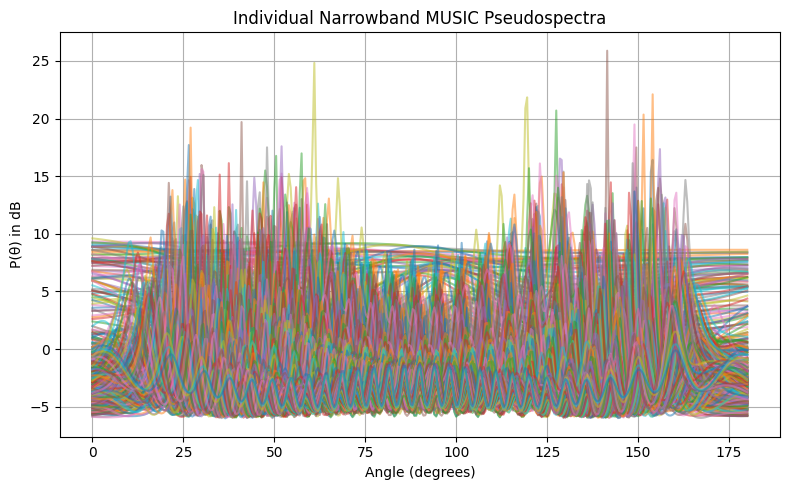

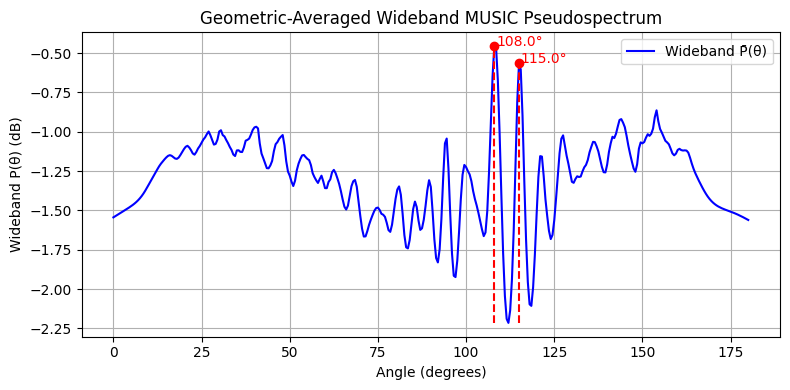

(4, 2)


In [22]:
# Head-mounted 
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def steering_vector_2d(mic_positions, theta_deg, freq, c):
    # Compute the steering vector for a given angle and frequency
    theta = np.deg2rad(theta_deg)
    
    k0 = 2.0 * np.pi * freq / c
    
    phase = k0 * (mic_positions[:, 0] * np.cos(theta)
                  + mic_positions[:, 1] * np.sin(theta))  # shape: (M,)
    
    a = np.exp(-1j * phase)
    return a

def music_wideband_HM(stft_mics, Q, c, mic_positions):
    M, nF, nT = stft_mics.shape
    
    theta_vals = np.arange(0, 180.5, 0.5)
    nTheta = len(theta_vals)
    
    freq_bins = range(1, nF-1)  
    nFreqUsed = len(freq_bins)
    
    all_pseudospec = np.zeros((nFreqUsed, nTheta), dtype=float)
    
    for i, fidx in enumerate(freq_bins):
        f_bin = f[fidx]
        
        X_omega = stft_mics[:, fidx, :]  # (M, nT)
        Rxx = (X_omega @ X_omega.conj().T) / nT  # Compute the covariance matrix
        
        eigenvals, eigenvecs = np.linalg.eig(Rxx)
        sort_idx = np.argsort(eigenvals)
        Un = eigenvecs[:, sort_idx[:(M-Q)]]  # (M, M-Q) noise subspace
        
        for j, theta_deg in enumerate(theta_vals):
            steer = steering_vector_2d(mic_positions, theta_deg, f_bin, c)
            
            v = Un.conj().T @ steer
            denom = np.abs(v @ v.conj())
            pseudospec = 1.0 / denom  # MUSIC spectrum estimation
            
            all_pseudospec[i, j] = pseudospec
    
    plt.figure(figsize=(8,5))
    for i in range(nFreqUsed):
        plt.plot(theta_vals, 10*np.log10(all_pseudospec[i, :]), alpha=0.5, label=f"bin {freq_bins[i]}")
    plt.title("Individual Narrowband MUSIC Pseudospectra")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("P(θ) in dB")
    plt.grid(True)
    # plt.legend(loc='best', ncol=2, fontsize='small')
    plt.tight_layout()
    plt.show()
    
    log_all = np.log(all_pseudospec + 1e-15)  # Avoid log(0)
    mean_log = np.mean(log_all, axis=0)      
    p_wideband = np.exp(mean_log)   # shape: (nTheta,)            
    
    peaks, properties = find_peaks(
        p_wideband,
        distance=5,     # Minimum separation between peaks (approximately 2.5° = 5 * 0.5°)
        prominence=0.1  # Adjust based on data
        # height=0.6*np.max(p_wideband)  # Filter out peaks below 60% of the maximum value
    )

    if len(peaks) == 0:
        print("Warning: no peak found!")
        doa_estimates = np.array([])
    else:
        peak_vals = p_wideband[peaks]
        if len(peaks) >= Q:
            idx_top = np.argsort(peak_vals)[-Q:]  # Select the top Q peaks
        else:
            idx_top = np.argsort(peak_vals)  
        idx_top_sorted = idx_top[np.argsort(peak_vals[idx_top])]
        
        peak_indices = peaks[idx_top_sorted]
        doa_estimates = theta_vals[peak_indices]  
    
    plt.figure(figsize=(8,4))
    plt.plot(theta_vals, 10*np.log10(p_wideband), 'b-', label='Wideband P̄(θ)')
    plt.grid(True)
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Wideband P(θ) (dB)")
    plt.title("Geometric-Averaged Wideband MUSIC Pseudospectrum")
    
    for doa in doa_estimates:
        val_db = 10*np.log10(p_wideband[theta_vals == doa])
        plt.plot(doa, val_db, 'ro')
        plt.vlines(doa, min(10*np.log10(p_wideband)), val_db, color='r', linestyles='--')
        plt.text(doa+0.5, val_db, f"{doa:.1f}°", color='red')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return doa_estimates

mic_positions = np.array([
    [0, 0],       # L1
    [0, -0.013],  # L2
    [0.215, 0],   # R1
    [0.215, -0.013]  # R2
])

c = 340

doa_estimates_wideband = music_wideband_HM(stft_mics, 2, c, mic_positions)

print(mic_positions.shape)


# Signal processing - Week 3: DOA-informed Beamforming

this is done 1 times
this is done 2 times
this is done 3 times
this is done 4 times
this is done 5 times
SNR in Mic 1: 4.6949387801767015 dB


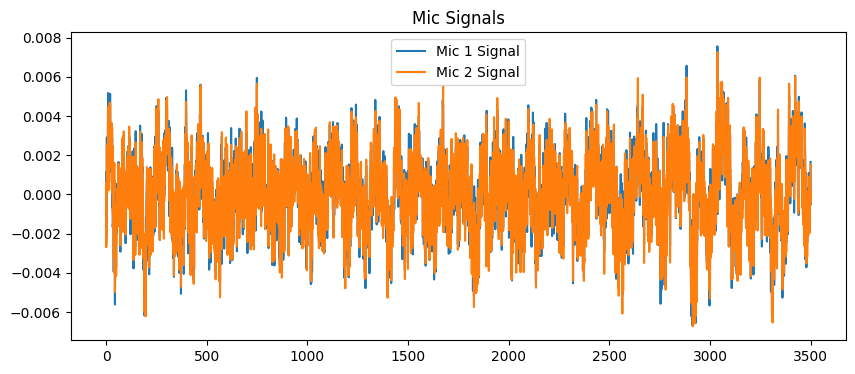

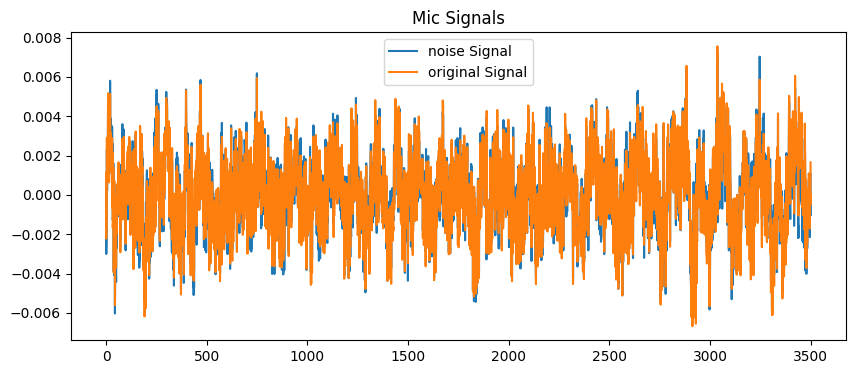

(220500, 5)
(220500, 5)
(220500, 5)


KeyboardInterrupt: 

In [85]:
# Part 1

import scipy
import numpy as np
import soundfile as sf
import scipy.signal as signal
import sounddevice as sd

def create_micsigs(target_audio_files, noise_audio_files, acousticScenario, T_s, hmr_paths):
    # Check if fs is 44.1 kHz
    fs = acousticScenario.fs
    if fs != 44100:
        raise ValueError("Sampling frequency must be 44.1 kHz")

    if len(hmr_paths) == 0:
        
        num_micro = acousticScenario.RIRsAudio.shape[1]  # number of microphones
        T_ds = int(T_s * fs)

        # Load and resample target audio sources
        speech_components = []
        for file in target_audio_files:
            speech, fs_audio = sf.read(file)
            
            speech_resampled = signal.resample(speech, int(len(speech) * fs / fs_audio)) if fs != fs_audio else speech
            speech_padded = np.pad(speech_resampled[:T_ds], (0, max(0, T_ds - len(speech_resampled))))
            speech_components.append(speech_padded)
        
        # Load and resample noise sources
        noise_components = []
        for file in noise_audio_files:
            noise, fs_noise = sf.read(file)
            
            noise_resampled = signal.resample(noise, int(len(noise) * fs / fs_noise)) if fs != fs_noise else noise
            noise_padded = np.pad(noise_resampled[:T_ds], (0, max(0, T_ds - len(noise_resampled))))
            noise_components.append(noise_padded)

        mic_signals = np.zeros((T_ds, num_micro))
        speech_3 = np.zeros((T_ds, 1))  # Placeholder for speech signal in the first mic
        noise_3 = np.zeros((T_ds, 1))  # Placeholder for noise in the first mic
        noise_sources_signal = np.zeros((T_ds, 1))  # Placeholder for noise sources in the first mic
        received_speech = np.zeros((T_ds, num_micro))
        
        received_noise = np.zeros((T_ds,num_micro))
        for mic_idx in range(num_micro):
            mic_signal = np.zeros(T_ds)
            for audio_idx, speech in enumerate(speech_components):
                rir_speech = acousticScenario.RIRsAudio[:, mic_idx, audio_idx]
                #rir_speech /= np.max(np.abs(rir_speech))
                
                received_speech[:, mic_idx] += signal.fftconvolve(speech, rir_speech, mode='same')
                mic_signal += signal.fftconvolve(speech, rir_speech, mode='same')

            for noise_idx, noise in enumerate(noise_components):
                rir_noise = acousticScenario.RIRsNoise[:, mic_idx, noise_idx]
                #rir_noise /= np.max(np.abs(rir_noise))
                received_noise[:, mic_idx] += signal.fftconvolve(noise, rir_noise, mode='same') 
                mic_signal += signal.fftconvolve(noise, rir_noise, mode='same')
                
                if mic_idx == 0:
                    noise_sources_signal[:, 0] += signal.fftconvolve(noise, rir_noise, mode='same')
            
            mic_signals[:, mic_idx] += mic_signal

            # Add noise to the first microphone signal
            if mic_idx == 0:
                vad = abs(received_speech[:,0]) > np.std(received_speech[:,0]) * 1e-3
                active_speech = received_speech[vad,0]
                P_speech = np.var(active_speech)
                P_noise_sources = np.var(noise_sources_signal[:, 0])
                noise_power = 0.1 * P_speech
                noise_signal = np.random.normal(0, np.sqrt(noise_power), len(speech_components[0]))
                noise_3[:, 0] = noise_signal  # Store additional noise signal

                # Add noise to the microphone signal
                i = 0
                for mic_idxx in range(num_micro):
                    i += 1
                    print("this is done", i, "times")
                    mic_signals[:, mic_idxx] += noise_signal
                    received_noise[:, mic_idxx] += noise_signal
                    

        # Compute SNR for the first microphone
        P_noise_total = np.var(noise_3[:, 0]) + P_noise_sources
        SNR = 10 * np.log10(P_speech / P_noise_total)
        print(f"SNR in Mic 1: {SNR} dB")

    else:
        all_paths = []
        for fpath in hmr_paths:
            all_paths.append([fpath + "/HMIR_L1.wav", fpath + "/HMIR_L2.wav", fpath + "/HMIR_R1.wav", fpath + "/HMIR_R2.wav"])
        fs = sf.read(all_paths[0][0])[1]
        T_ds = int(T_s * fs)

        # Load and resample target audio sources
        speech_components = []
        noise_components = []
        for file in target_audio_files:
            speech, fs_audio = sf.read(file)
            fs = fs_audio
            speech_resampled = signal.resample(speech, int(len(speech) * fs / fs_audio)) if fs != fs_audio else speech
            speech_padded = np.pad(speech_resampled[:T_ds], (0, max(0, T_ds - len(speech_resampled))))
            speech_components.append(speech_padded)

        num_micro = 4
        mic_signals = np.zeros((T_ds, num_micro))
        received_speech = np.zeros((T_ds, num_micro))
        received_noise = np.zeros((T_ds, num_micro))
        for mic_idx in range(num_micro):
            mic_signal = np.zeros(T_ds)
            for audio_idx, speech in enumerate(speech_components):
                rir_speech = sf.read(all_paths[audio_idx][mic_idx])[0]
                #rir_speech /= np.max(np.abs(rir_speech))
                received_speech[:, mic_idx] += signal.fftconvolve(speech, rir_speech, mode='same')
                mic_signal += signal.fftconvolve(speech, rir_speech, mode='same')

            mic_signals[:, mic_idx] = mic_signal

    return mic_signals, received_speech, received_noise, fs


# Example usage
Time_duration = 5
mic, speech, noise, _ = create_micsigs(["C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/part1_track1_dry.wav","C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/part1_track2_dry.wav"], ["C:/Users/uprub/Documents/PandD/pandd2023-base/sound_files/Babble_noise1.wav"], acousticScenario, Time_duration, [])
comb = speech[5500:9000, 0] + noise[5500:9000, 0]
plt.figure(figsize=(10, 4))
plt.plot(mic[5500:9000, 0], label="Mic 1 Signal")
plt.plot(mic[5500:9000, 1], label="Mic 2 Signal")
plt.legend()
plt.title("Mic Signals")
plt.show()
plt.figure(figsize=(10, 4))
plt.plot(noise[5500:9000, 0], label="noise Signal")
plt.plot(comb, label="original Signal")
plt.legend()
plt.title("Mic Signals")
plt.show()

# Print shape of the microphone signals
print(mic.shape)
print(speech.shape)
print(noise.shape)
sd.play(mic[:, 0], samplerate=acousticScenario.fs)
sd.wait()  # Wait until playback finishes

In [ ]:
def delay_and_sum(signals, fs, dist, c, theta):
    """
    signals: shape (N, M), N sample points, M microphones
    fs     : sampling rate
    dist   : microphone spacing
    c      : speed of sound
    theta  : angle of incidence (radians)
    
    Returns: single-channel DAS output with shape (N,)
    """
    N, M_ = signals.shape
    output = np.zeros(N)
    
    for m in range(M_):
        # Position of microphone m (if the first microphone is at coordinate 0, then m is at distance m * dist)
        mic_pos = m * dist
        # End-fire = 0° => use cos(theta), Broadside = 90° => use sin(theta)
        # Below assumes that 90° is directly facing the microphone array (i.e., broadside)
        delay_secs = (mic_pos * np.sin(theta)) / c
        delay_samples = int(round(delay_secs * fs))

        # Apply a simple integer delay to signals[:, m] (if negative, special handling can be done)
        shifted = np.zeros_like(signals[:, m])
        if delay_samples >= 0:
            if delay_samples < N:
                shifted[delay_samples:] = signals[:-delay_samples, m]
            # If delay_samples >= N, the entire segment is shifted out => all zeros
        else:
            # Negative delay (for cases like end-fire), can be handled
            # Simple example below: shift forward by |delay_samples|:
            dly = -delay_samples
            if dly < N:
                shifted[:N-dly] = signals[dly:, m]

        output += shifted  # Accumulate
    return output
